<a href="https://colab.research.google.com/github/jessicanadalete/clustering_fidelity/blob/main/Clustering_Fidelity_Project_Cycle3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.0 Import Libraries
-----

In [1]:
pip install inflection

In [2]:
pip install umap-learn

In [77]:
import inflection
import datetime
import re
import pandas       as pd
import numpy        as np
import seaborn      as sns
import umap.umap_   as umap

from sklearn              import cluster        as c
from sklearn              import metrics        as m
from sklearn              import preprocessing  as pp

from yellowbrick.cluster  import KElbowVisualizer
from yellowbrick.cluster  import SilhouetteVisualizer
from matplotlib           import pyplot         as plt
from plotly               import express        as px

### 0.1 Load Dataset

In [4]:
data_raw = pd.read_csv('/content/Ecommerce.csv', encoding='unicode_escape')

## 1.0 Data Description

---






In [5]:
df1 = data_raw.copy()

###1.1 Data Dimension

In [6]:
df1.shape

(541909, 9)

In [7]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [8]:
df1 = df1.drop('Unnamed: 8', axis=1)

In [9]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### 1.2 Rename Columns

In [10]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

In [12]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.3 Data Types

In [13]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,float64
customer_id,float64
country,object


### 1.4 Check NAs

In [14]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,1454
quantity,0
invoice_date,0
unit_price,0
customer_id,135080
country,0


### 1.5 Remove/Replace NAs

In [15]:
df1 = df1.dropna(subset=['description','customer_id'])

In [16]:
df1.shape

(406829, 8)

In [17]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


###1.6 Change Types

In [18]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

In [19]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [20]:
df1['unit_price'] = df1['unit_price'].astype(float)

In [21]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,datetime64[ns]
unit_price,float64
customer_id,int64
country,object


###1.7 Statistic Description

In [22]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

###1.7.1 Numerical Attributes

In [23]:
#central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T #range
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


###<font color='red'>1.7.1.1 Numerical Attributes - Investigating </font>
1. Negative values in Quantity (devolution?)
2. Unity price equal to zero (sale?)




###1.7.2 Categorical Attributes

In [24]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [31]:
#analising why cant change invoice type to int

#cat_attributes['invoice_no'].astype(int)
#len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool (re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())
len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool (re.search('[^0-9]+', x))), 'invoice_no'])

8905

In [35]:
#analising if all invoice with letters are negative
df_invoice_letters = df1.loc[df1['invoice_no'].apply(lambda x: bool (re.search('[^0-9]+', x))), :]
len(df_invoice_letters)

8905

In [36]:
len(df_invoice_letters[df_invoice_letters['quantity']<0]) #we can assume all invoice with letters are negative (devlution for example)

8905

In [38]:
df_invoice_letters['quantity'].max() #all negatives

-1

In [26]:
len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool (re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

886

In [27]:
#analising stock code with only letters
df1.loc[cat_attributes['stock_code'].apply(lambda x: bool (re.search('^[A-Za-z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [39]:
#analising description
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [42]:
#analising country
df1['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [49]:
df1['country'].drop_duplicates().count()

np.int64(37)

In [45]:
#df1['country'].value_counts()
df1['country'].value_counts(normalize=True)

,proportion
country,
United Kingdom,0.889509
Germany,0.023339
France,0.020871
EIRE,0.018398
Spain,0.006226
Netherlands,0.005828
Belgium,0.005086
Switzerland,0.004614
Portugal,0.003638


## 2.0 Data Filtering
-----

In [50]:
df2 = df1.copy()

In [51]:
#removing data unit price <0.0
df2 = df2.loc[df2['unit_price']>0.04,:]

#removing stock code = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

#filtering data based on quantity to create new features
df2_returns = df2.loc[df2['quantity']<0,:]
df2_purchase = df2.loc[df2['quantity']>0,:]

#cleaning country variables to be able to use lat/long variable
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

#filtering description
df2 = df2.drop(columns='description', axis=1)

## 3.0 Feature Engineering
-----

In [52]:
df3 = df2.copy()

###3.1 Feature Creation

In [53]:
#data reference - creating a dataframe with unique values
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True) #extrating customer_ids and reseting index

In [54]:
# creating Gross Revenue variable (Faturamento)
df2_purchase.loc[:,'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:,'unit_price']

In [55]:
# creating Monetary (value spent by customer)
df_monetary = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

# creating Recency variable (last date purchase)
df_recency = df2_purchase[['customer_id','invoice_date']].groupby('customer_id').max().reset_index() # getting the last date purchase by customer
df_recency['recency_days'] = (df2_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days # calculating and extrating days quantity
df_recency = df_recency[['customer_id','recency_days']].copy() #selecting columns

# creating Frequency (purchase quantities)
df_frequency = df2_purchase[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

In [56]:
#creating avg ticket (value average by custumer)
df_avg_ticket = df2_purchase[['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})

In [ ]:
#creating returns dataframe
#df_returns = df2_returns[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'returns'})

In [57]:
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')
#df_ref = pd.merge(df_ref, df_returns, on='customer_id', how='left')

In [58]:
df_ref.isna().sum()

,0
customer_id,0
gross_revenue,27
recency_days,27
invoice_no,27
avg_ticket,27


## 4.0 EDA (Exploratory Data Analysis)
-----

In [59]:
df4 = df_ref.dropna().copy()

In [60]:
df4.isna().sum()

,0
customer_id,0
gross_revenue,0
recency_days,0
invoice_no,0
avg_ticket,0


## 5.0 Data Preparation
-----

In [61]:
df5 = df4.copy()

In [78]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

In [79]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.377193,2.791512,3.889210,-0.033939
1,13047,0.135388,-0.361004,0.620928,-0.033427
2,12583,0.524404,-0.899726,1.405316,-0.026622
3,13748,-0.120499,0.028072,0.098003,-0.023244
4,15100,-0.128592,2.402435,-0.163459,0.152443


## 6.0 Feature Selection
-----

In [80]:
df6 = df5.copy()

## 7.0 Hyperparameter Fine-Tunning
-----

In [81]:
df7 = df6.copy()

In [82]:
X = df7.drop(columns = ['customer_id']) #droping variable without information

In [83]:
X.head()

,gross_revenue,recency_days,invoice_no,avg_ticket
0,0.377193,2.791512,3.889210,-0.033939
1,0.135388,-0.361004,0.620928,-0.033427
2,0.524404,-0.899726,1.405316,-0.026622
3,-0.120499,0.028072,0.098003,-0.023244
4,-0.128592,2.402435,-0.163459,0.152443


In [84]:
clusters = [2,3,4,5,6,7]

###7.1 Within-Cluster Sum of Square (WSS)

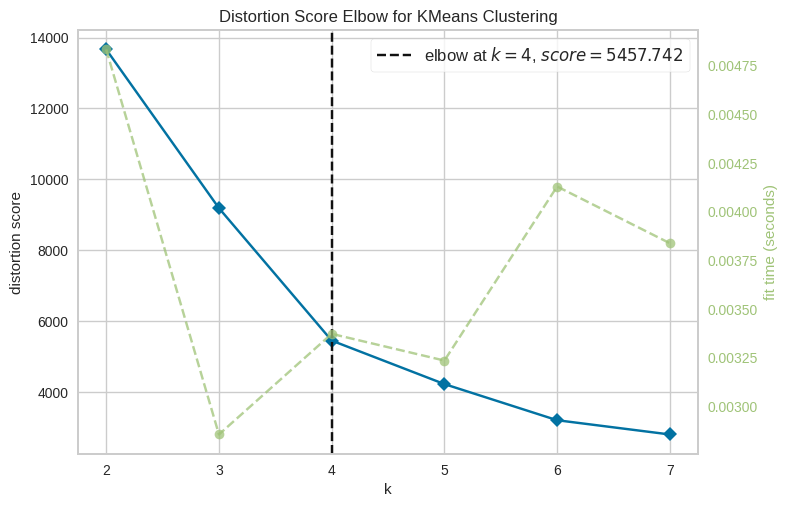

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [85]:
#model defining and analyzing Elbow
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show()

###7.2 Silhouette Score

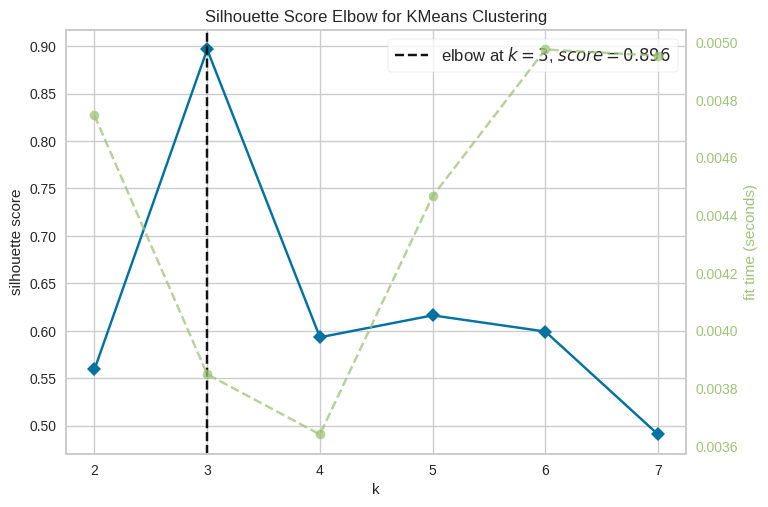

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [86]:
#model defining and analyzing Elbow
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show()

##7.3 Silhouette Analysis

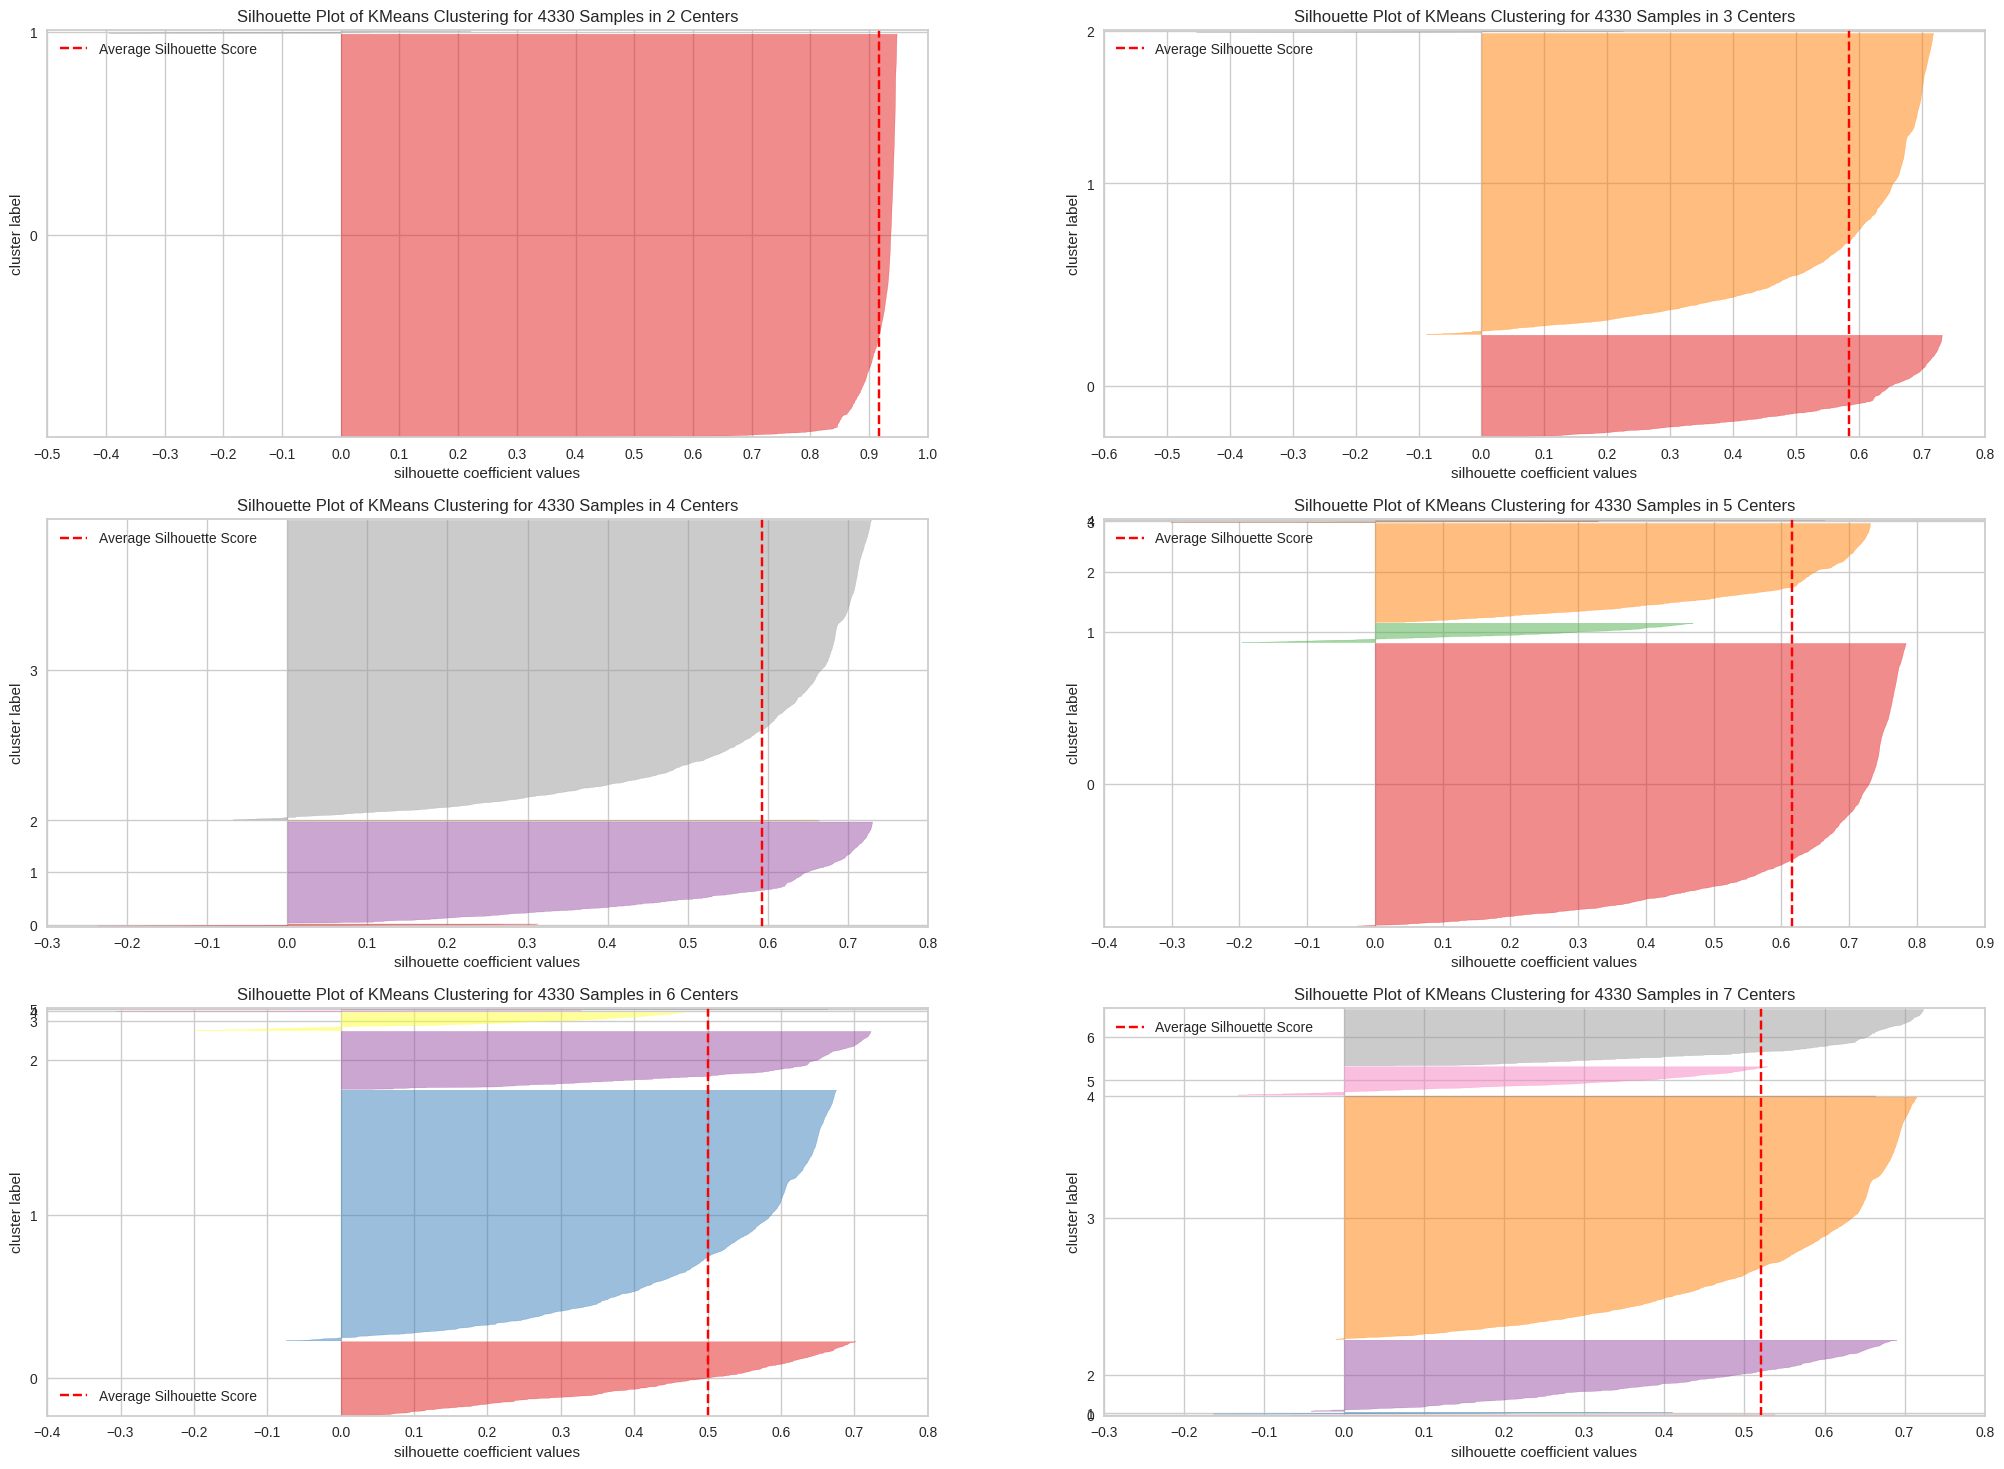

In [87]:
fig, axes = plt.subplots(3, 2, figsize=(25, 18))

# transform 2d matrix to a list
axes = axes.flatten()

for i, k in enumerate(clusters):
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=axes[i])
    visualizer.fit(X)
    visualizer.finalize()

In [ ]:
# fig, ax = plt.subplots (3,2,figsize=(25,18))
# for k in clusters:
#   km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
#   q, mod = divmod(k,2)
#   visualizer = SilhouetteVisualizer(km, color='yellowbricks', ax=ax[q-1][mod])
#   visualizer.fit(X)
#   visualizer.finalize()

## 8.0 Model Training
-----

###8.1 K-means Model

In [88]:
# model definition
k = 3
kmeans = c.KMeans (init='random', n_clusters=k,n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

###8.2 Cluster Validation

In [89]:
# WSS
print('WSS value {}'.format(kmeans.inertia_))

#Silhouette Score
print('Silhouette Score {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value 9312.908811188936
Silhouette Score 0.5842412867210133


## 9.0 Cluster Analysis
-----

In [90]:
df9 = df7.copy()

In [91]:
df9['cluster'] = labels

###9.1 Visualization Inspection

In [74]:
fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
fig.show()

### 2D Plot

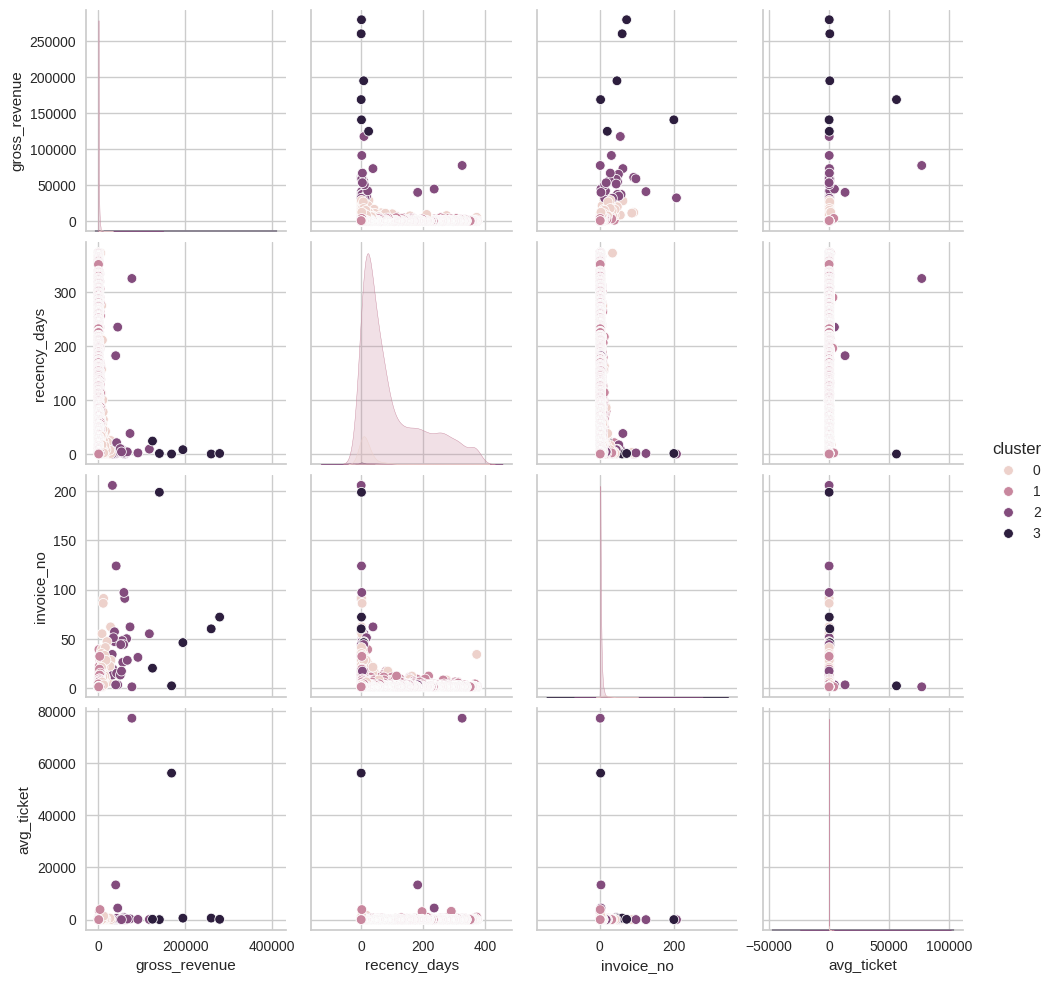

In [75]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### UMAP - t-SNE (Manifold - Learning by topology)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



<Axes: xlabel='embedding_x', ylabel='embedding_y'>

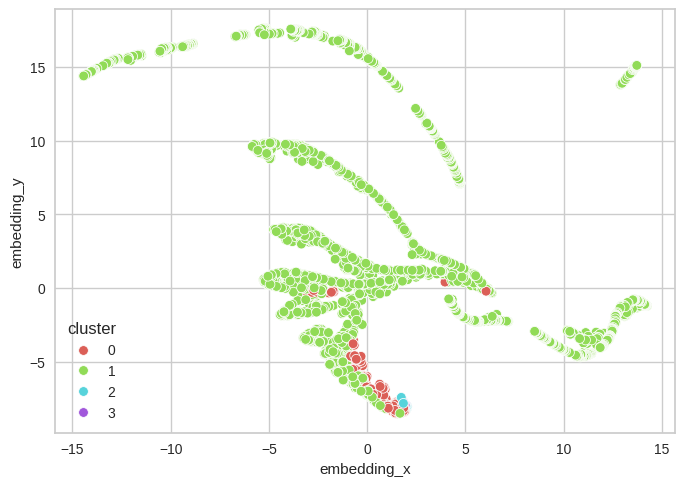

In [92]:
reducer = umap.UMAP(n_neighbors=50, random_state=42)
embedding = reducer.fit_transform(X) #projecting space

df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster',
                palette=sns.color_palette('hls', n_colors=df_viz['cluster'].nunique()),
                data=df_viz)

###9.2 Cluster Profile

In [ ]:
#Number of customer by cluster
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['percentage'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum())
df_cluster

In [ ]:
# Gross Revenue Average
df_gr_avg = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gr_avg, how='inner', on='cluster')
df_cluster

In [ ]:
# Recency Days Average
df_gr_avg = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gr_avg, how='inner', on='cluster')
df_cluster

In [ ]:
# Invoice_no Average
df_gr_avg = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gr_avg, how='inner', on='cluster')
df_cluster

In [ ]:
#Ticket Average
ticket_avg = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, ticket_avg, how='inner', on='cluster')
df_cluster

##Report
### Cluster 1 (Potential Insider):
- Customers: 6 (0.14% of total customer)
- Recency Average: 7 days
- Purchase Average: 89 purchases
- Gross Revenue Average: $182,182.00

### Cluster 2:
- Customers: 13 (0.7% of total customer)
- Recency Average: 14 days
- Purchase Average: 53 purchases
- Gross Revenue Average: $40,543.50

### Cluster 3:
- Customers: 4335 (99% of total customer)
- Recency Average: 92 days
- Purchase Average: 5 purchases
- Gross Revenue Average: $1,372.50


## 10.0 Deploy to Production
-----